# Распознавание кошек и собак

Для распознавания используется сверточная нейронная сеть.
Основное содержание:
- подключение архива данных
- просмотр содержания дата сета
- создание сверточной сети и ее просмотр
- компиляция сети
- создание генераторов изображений для тренировки и проверки
- обучение нейросети
- оценка качества и вывод графика
- сохранение модели нейросети (структуры и весов), в облако и на локальный компьютер
- загрузка модели нейросети (с новым названием)
- компиляция загруженной нейросети
- распознавание собственных  картинок (загрузка, просмотр, подготовка, классификация на нейросети)




In [ ]:
# ИМпорт библиотек для работы с файловой системой
# для операций с файлами и каталогами (копирование, перемещение, создание, удаление)
import shutil
import os
from matplotlib import pyplot as plt

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense



Вспомогательные функции

In [ ]:
from os import listdir, sep
from os.path import abspath, basename, isdir
def tree(dir, padding= '  ', print_files=False):
    """
    Эта функция строит дерево поддиректорий и файлов для заданной директории

    Параметры
    ----------
    dir : str
        Path to needed directory
    padding : str
        String that will be placed in print for separating files levels
    print_files : bool
        "Print or not to print" flag
    """
    cmd = "find '%s'" % dir
    files = os.popen(cmd).read().strip().split('\n')
    padding = '|  '
    for file in files:
        level = file.count(os.sep)
        pieces = file.split(os.sep)
        symbol = {0:'', 1:'/'}[isdir(file)]
        if not print_files and symbol != '/':
            continue
        print (padding*level + pieces[-1] + symbol)

In [ ]:
def plot_cats_dogs_samples(train_dir, N=4):
  """
    Эта функция строит N самплов каждого класса из датасета Cats vs Dogs

    Параметры
    ----------
    train_dir : str
        Directory with train Cats vs Dogs dataset
    N : int
        Number of samples for each class
  """
  import random
  fig, ax = plt.subplots(2,N,figsize=(5*N,5*2))

  for i,name in enumerate(['cat','dog']):
    filenames = os.listdir(os.path.join(train_dir,name))

    for j in range(N):
      sample = random.choice(filenames)
      image = load_img(os.path.join(train_dir,name,sample))
      ax[i][j].imshow(image)
      ax[i][j].set_xticks([])
      ax[i][j].set_yticks([])
      ax[i][j].set_title(name)
  plt.grid(False)
  plt.show()

In [ ]:
# Импортируем функцию для загрузки картинок из файлов и генератор картинок
from keras.preprocessing.image import load_img, ImageDataGenerator

In [ ]:
# Каталог с данными для обучения
train_dir = 'train'
# Каталог с данными для проверки
val_dir = 'val'
# Каталог с данными для тестирования
test_dir = 'test'
# Размеры изображения
img_width, img_height = 150, 150
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, 3)
# Количество эпох
epochs = 5
# Размер мини-выборки
batch_size = 16
# Количество изображений для обучения
nb_train_samples = 22500
# Количество изображений для проверки
nb_validation_samples = 2500
# Количество изображений для тестирования
nb_test_samples = 2500



# Набор данных
Набор данных берется по ссылке из интернета. Можно использовать другие наборы - указать иную ссылку, в том числе ссылку на размещение архива на гугл-диске
Набор данных организуется в виде архива, где есть главная директория и поддиректории для обучения и тестирования. В каждой из них - поддиректори  с кошками и собаками.


In [ ]:
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
#!wget -c https://drive.google.com/file/d/1rvQEbpU2lvz_hGFteYwDYZGa0fg37mWl/view?usp=sharing
!unzip -qq Cat_Dog_data.zip

--2024-02-13 12:39:42--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.235.72, 54.231.131.240, 54.231.137.160, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.235.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  46.1MB/s    in 13s     

2024-02-13 12:39:55 (42.5 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



In [ ]:
base_dir = 'Cat_Dog_data'


train_dir = os.path.join(base_dir, 'train')

test_dir = os.path.join(base_dir, 'test')

In [ ]:
# Посмотрим, как именно расположены директории с датасетом относительно друг друга
tree(base_dir,print_files=False)

Cat_Dog_data/
|  train/
|  |  cat/
|  |  dog/
|  test/
|  |  cat/
|  |  dog/


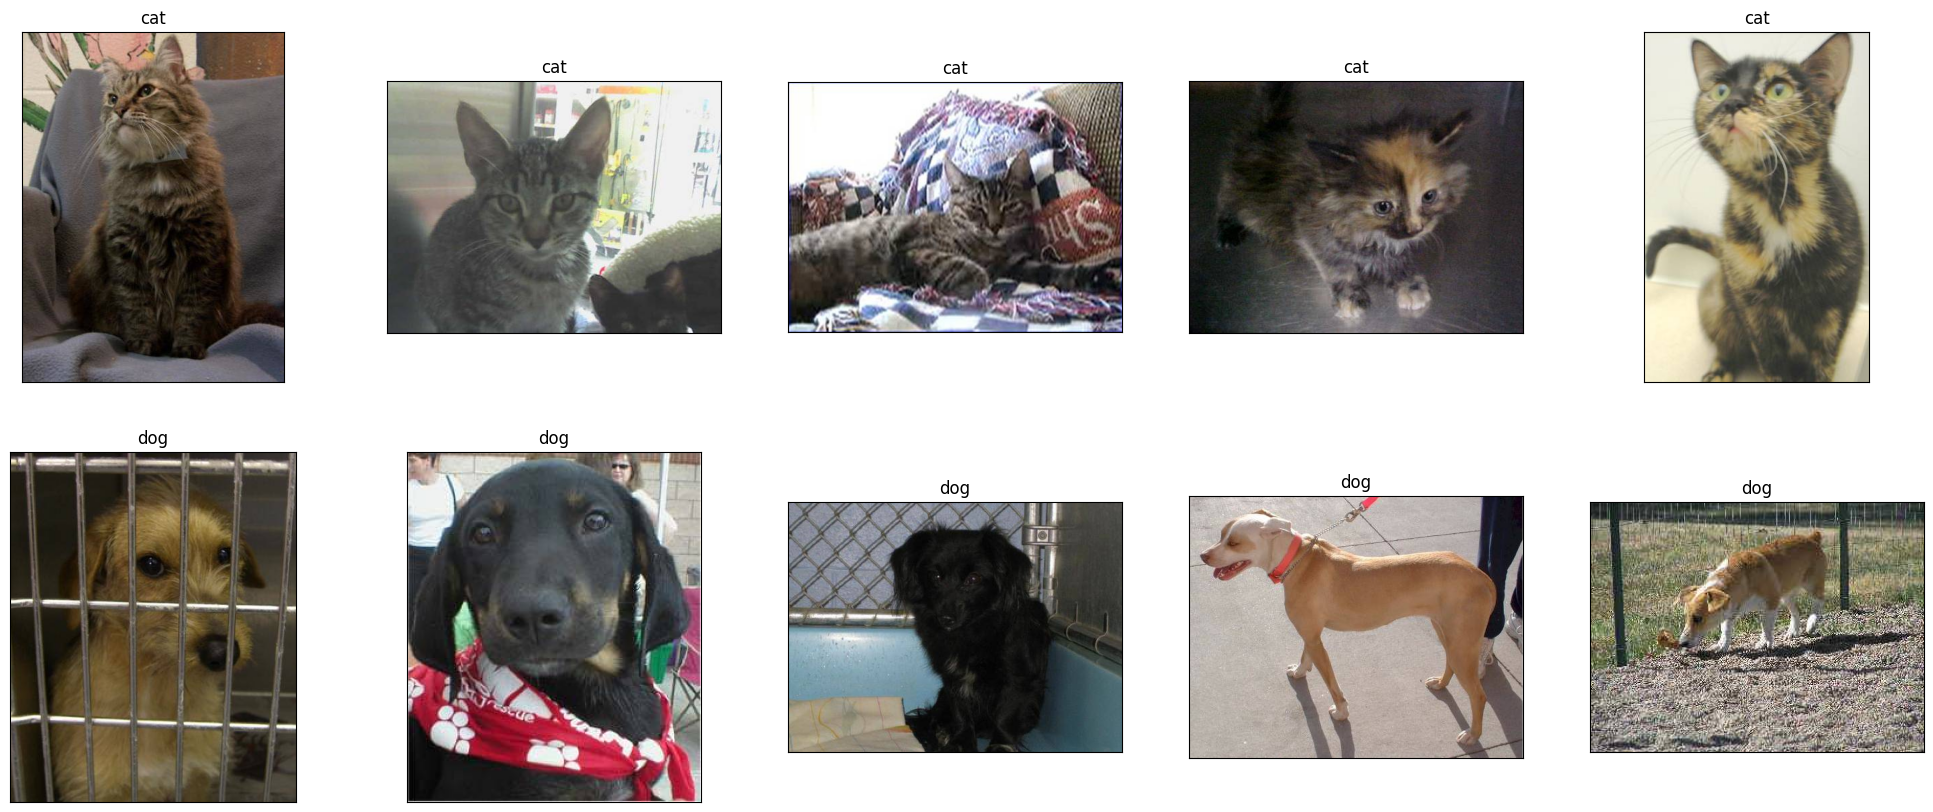

In [ ]:
#Посмотрим на содержание датасета при помощи функции plot_cats_dogs_samples
plot_cats_dogs_samples(train_dir, N=5)


Создаем сверточную нейронную сеть¶

Архитектура сети

    Слой свертки, размер ядра 3х3, количество карт признаков - 32 шт., функция активации ReLU.
    Слой подвыборки, выбор максимального значения из квадрата 2х2
    Слой свертки, размер ядра 3х3, количество карт признаков - 32 шт., функция активации ReLU.
    Слой подвыборки, выбор максимального значения из квадрата 2х2
    Слой свертки, размер ядра 3х3, количество карт признаков - 64 шт., функция активации ReLU.
    Слой подвыборки, выбор максимального значения из квадрата 2х2
    Слой преобразования из двумерного в одномерное представление
    Полносвязный слой, 64 нейрона, функция активации ReLU.
    Слой Dropout.
    Выходной слой, 1 нейрон, функция активации sigmoid

Слои с 1 по 6 используются для выделения важных признаков в изображении, а слои с 7 по 10 - для классификации.


In [ ]:
model = Sequential()

# Первый сверточный слой
model.add(Conv2D(32, (3, 3), input_shape=(input_shape), activation='relu'))
# Первый слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))

# Второй сверточный слой
model.add(Conv2D(32, (3, 3), activation='relu'))
# Второй слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))

# Третий сверточный слой
model.add(Conv2D(64, (3, 3), activation='relu'))
# Третий слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))

# Преобразование из двумерного в одномерное представление
model.add(Flatten())

# Полносвязный слой
model.add(Dense(64, activation='relu'))

# Слой Dropout
model.add(Dropout(0.5))

# Выходной слой
model.add(Dense(1, activation='sigmoid'))

далее посмотрим, что из себя представляет эта сеть


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

Компилируем нейронную сеть

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Создаем генератор изображений

Генератор изображений создается на основе класса ImageDataGenerator. Генератор делит значения всех пикселов изображения на 255.


In [ ]:
datagen = ImageDataGenerator(rescale=1. / 255)

Генератор данных для обучения на основе изображений из каталога


In [ ]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 22500 images belonging to 2 classes.


Генератор данных для проверки на основе изображений из каталога


In [ ]:
test_generator = datagen.flow_from_directory(
    #val_dir,
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 2500 images belonging to 2 classes.


Генератор данных для тестирования на основе изображений из каталога


In [ ]:
#Обучаем модель с использованием генераторов

#train_generator - генератор данных для обучения

#validation_data - генератор данных для проверки - у меня пока не используется
#test_generator - генератор данных для тестирования

In [ ]:
#
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/5
1406/1406 [==============================] - 51s 32ms/step - loss: 0.6511 - accuracy: 0.6123 - val_loss: 0.5503 - val_accuracy: 0.7228
Epoch 2/5
1406/1406 [==============================] - 44s 32ms/step - loss: 0.5313 - accuracy: 0.7394 - val_loss: 0.4869 - val_accuracy: 0.7776
Epoch 3/5
1406/1406 [==============================] - 43s 30ms/step - loss: 0.4607 - accuracy: 0.7850 - val_loss: 0.4520 - val_accuracy: 0.7941
Epoch 4/5
1406/1406 [==============================] - 43s 31ms/step - loss: 0.4119 - accuracy: 0.8106 - val_loss: 0.4309 - val_accuracy: 0.8101
Epoch 5/5
1406/1406 [==============================] - 43s 30ms/step - loss: 0.3763 - accuracy: 0.8320 - val_loss: 0.4252 - val_accuracy: 0.8209


Оцениваем качество работы сети с помощью генератора


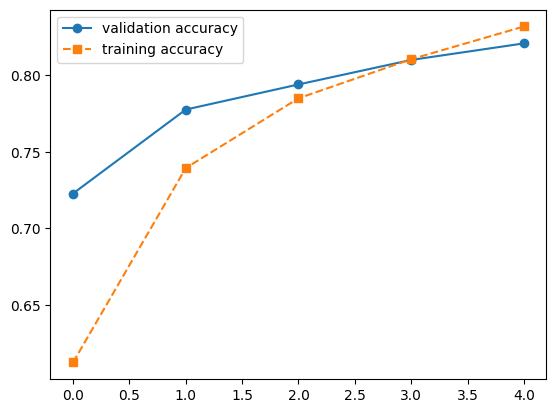

In [ ]:
# Построим изменение точности на трейновой (оранжевая линия) и тестовой (синяя линия)
# выборках
plt.plot(history.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(history.history['accuracy'], '--s', label='training accuracy')
plt.legend();

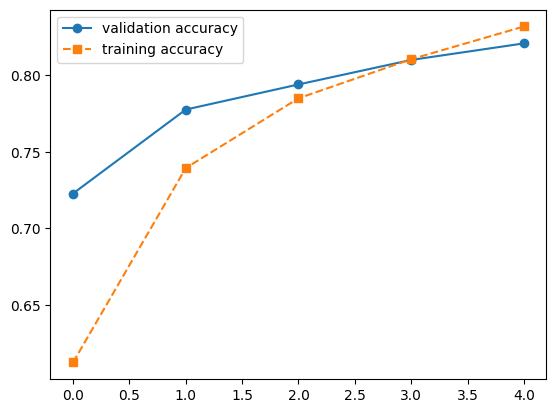

In [ ]:
# Построим изменение точности на трейновой (оранжевая линия) и тестовой (синяя линия)
# выборках
plt.plot(history.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(history.history['accuracy'], '--s', label='training accuracy')
plt.legend();

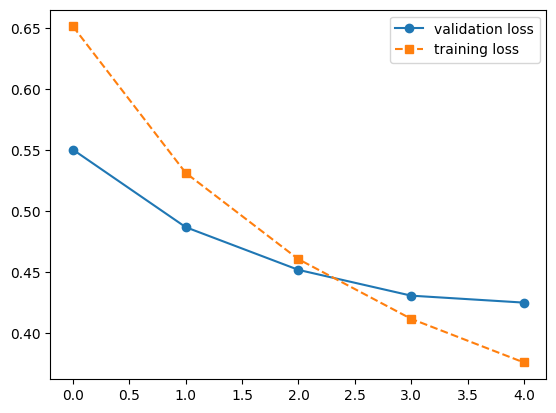

In [ ]:
# Построим изменение точности на трейновой (оранжевая линия) и тестовой (синяя линия)
# выборках
plt.plot(history.history['val_loss'], '-o', label='validation loss')
plt.plot(history.history['loss'], '--s', label='training loss')
plt.legend();

In [ ]:
# Взглянем на итоговые результаты классификации на тестовой выборке
# (функция ошибки, точность)
model.evaluate(test_generator)

157/157 [==============================] - 4s 24ms/step - loss: 0.4249 - accuracy: 0.8212


[0.42494234442710876, 0.8212000131607056]

Далее сохраним модель сети



Подробнее про сохранение и считывание модели - см. здесь https://blog.stroganov.pro/%D1%81%D0%BE%D1%85%D1%80%D0%B0%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8-%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%BE%D0%B9-%D1%81%D0%B5%D1%82%D0%B8/

Там же смотри подробнее про сохранение/считывание весов


In [ ]:
print("Сохраняем сеть")
# Сохраняем сеть для последующего использования
# Генерируем описание модели в формате json
model_json = model.to_json()
json_file = open("CAT_and_DOG.json", "w")
# Записываем архитектуру сети в файл
json_file.write(model_json)
json_file.close()
# Записываем данные о весах в файл
model.save_weights("CAT_and_DOG.h5")
print("Сохранение сети завершено")

Сохраняем сеть
Сохранение сети завершено


In [ ]:
#сохраняем на локальном компьютере
from google.colab import files
files.download("CAT_and_DOG.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#сохраняем веса сети
files.download("CAT_and_DOG.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Загружаем сохраненную сеть


In [ ]:
from keras.models import model_from_json

Далее мы можем проводить с переменной loaded_model все стандартные процедуры, обучать, прогнозировать, но сначала ее нужно скмопилировать, т.е.  вызвать ее метод compile.

In [ ]:
with open("CAT_and_DOG.json", "r") as file_json:
    json = file_json.read()
loaded_model = model_from_json(json)

loaded_model.load_weights("CAT_and_DOG.h5")

loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Распознавание своего изображения



In [ ]:
from IPython.display import Image
from keras.preprocessing import image

In [ ]:
cat = files.upload()

Saving cat.jpeg to cat.jpeg


In [ ]:
dog = files.upload()

Saving dog.jpeg to dog.jpeg


In [ ]:
#смотрим, что есть в облачном хранилище, есть ли там наша картинка
!ls


'cat (1).jpeg'	'cat (3).jpeg'	 CAT_and_DOG.h5     Cat_Dog_data       cat.jpeg   __MACOSX
'cat (2).jpeg'	'cat (4).jpeg'	 CAT_and_DOG.json   Cat_Dog_data.zip   dog.jpeg   sample_data


In [ ]:
# если хочется посмотреть текущйи каталог]
#!pwd
!ls /content/bin


ls: cannot access '/content/bin': No such file or directory


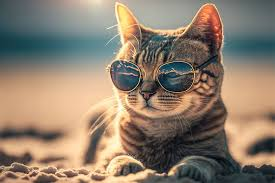

In [ ]:
#Покажем файл в облачном хранилище
Image ('cat.jpeg')

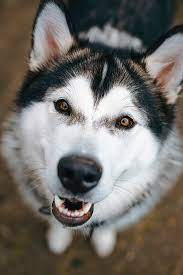

In [ ]:
Image ('dog.jpeg')

In [ ]:
catPath = 'cat.jpeg'
dogPath = 'dog.jpeg'

In [ ]:
# Преобразуем картинку в вектор , массив numpy
Image(catPath, width=150, height=150)
import numpy as np
#устанавливаем целевой размер, как и ранее при обучении - 150 на 150
cat_img = image.load_img(catPath, target_size=(150, 150), grayscale=False)
# Преобразуем изображением в массив numpy
cat_x = image.img_to_array(cat_img)
cat_x = 255 - cat_x
cat_x /= 255
cat_x = np.expand_dims(cat_x, axis=0)

In [ ]:
# Преобразуем картинку в вектор , массив numpy
Image(dogPath, width=150, height=150)
import numpy as np
#устанавливаем целевой размер, как и ранее при обучении - 150 на 150
dog_img = image.load_img(dogPath, target_size=(150, 150), grayscale=False)
# Преобразуем изображением в массив numpy
dog_x = image.img_to_array(dog_img)
dog_x = 255 - dog_x
dog_x /= 255
dog_x = np.expand_dims(dog_x, axis=0)

In [ ]:
#Распознавание с помощью исходной нейросети (которая не загружалась)
#prediction = model.predict(x)

Распознавание изображения
с помощью модели загруженной с компьютера нейросети


In [ ]:
cat_prediction = loaded_model.predict(cat_x)
print (cat_prediction)
dog_prediction = loaded_model.predict(dog_x)
print (dog_prediction)

1/1 [==============================] - 0s 18ms/step
[[0.0118948]]
1/1 [==============================] - 0s 18ms/step
[[0.8386764]]


In [ ]:
о#bbb = np.argmax(prediction) - это возврат значения индекса наибольшего значения в массиве,  унас всегда одно значение
bbb1 = np.around(cat_prediction, decimals=0)
print (bbb1[0])
print("Номер класса:", bbb1)
bbb2 = np.around(dog_prediction, decimals=0)
print (bbb2[0])
print("Номер класса:", bbb2)
#print("Название класса:", classes[prediction])

[0.]
Номер класса: [[0.]]
[1.]
Номер класса: [[1.]]
